In [3]:
from datetime import datetime, date
import copy as cp
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display

import statsmodels.formula.api as smf
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.gam.generalized_additive_model import LogitGam
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay

from pygam import LogisticGAM

DATA_PATH = ""
DATA_FN   = "cc_transactions.csv"
TODAY = date.today()

# Helper functions

In [2]:
def calc_age(birthday):
    birthday = datetime.strptime(birthday, "%Y-%m-%d").date()
    today = date.today()
    return today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))

#  <span style="font-family: Palatino; font-size: 30px; color:purple">The data </span>

The data can be found in the file `cc_tranactions.csv`.  

The dataset contains individual credit card transactions over a the period 01-01-2019 - 12-31-2021.  The transactions only represent a small subset of all users that we have sampled to keep the size of the dataset manageable.  The data dictionary is given below.

The data set contains 1,997,859 observations of 26 variables per transaction.

## Data Dictionary

 | __variable__   | __Description__ |
 | :--            | -:-             |
 | ` ssn `        | Social Security number 
 | ` cc_num `     | Credit card number 
 | ` first `      | First name
 | ` last `       | Last name
 | ` gender `     | Gender
 | ` street `     | Street address
 | ` city `       | City of residence
 | ` state `      | State of residence
 | ` zip `        | Postal code of residence
 | ` lat `        | Latitude of residence
 | ` long `       | Longitude of residence
 | ` city_pop   ` | Population of city of residence
 | ` job `        | Job title
 | ` dob `        | Date of birth
 | ` acct_num `   | User acct number
 | ` profile `    | Demographic cluster
 | ` trans_num `  | Transaction number
 | ` trans_date ` | Transaction date
 | ` trans_time ` | Transaction time
 | ` unix_time `  | UNIX time of transaction
 | ` category `   | Type of product
 | ` amt `        | Transaction amt
 | ` is_fraud `   | Dummy indicating fraud (1) or no-fraud (0)
 | ` merchant `   | Name of merchant executing transaction
 | ` merch_lat `  | Latitude of merchant location
 | ` merch_long ` | Longitude of merchant location
 

## Selected data summaries

### `is_fraud`

| __label__   | __count__ 
| :--   | :-- |    
| 0  |  1,990,508
| 1  |    7,351

### `profile`

 | __label__   | __count__ 
 | :--   | :-- |    
adults_2550_female_rural |  19738
adults_2550_female_urban | 573037
adults_2550_male_rural |    21969
adults_2550_male_urban |   497764
adults_50up_female_rural |   8756
adults_50up_female_urban | 299042
adults_50up_male_rural |    20862
adults_50up_male_urban |   303322
young_adults_female_rural |  7686
young_adults_female_urban    119580
young_adults_male_rural |    6577
young_adults_male_urban |  119526

### `category`

 | __Label__   | __count__ 
 | :--   | :-- |  
entertainment | 145896
food_dining |   150670
gas_transport | 170316
grocery_net |    86063
grocery_pos |   187250
health_fitness  |   124189
home |       186835
kids_pets |     174024
misc_net |    90653
misc_pos |   131483
personal_care | 141152
shopping_net |  146755
shopping_pos |  198182
travel |      64391

## Load the data


In [4]:
def read_data(file):
    df = pd.read_csv(file, parse_dates=True)#, index_col='Date')
    return df

transaction_data = read_data(DATA_PATH + DATA_FN)

# <span style="font-family: Palatino; font-size: 24px; color:purple">Model building </span>

## Preprocessing

### For each record, calculate the age of the customer based on `dob` and the day of the week of the transaction.

In [5]:
birthday = pd.to_datetime(transaction_data['dob'])
today = pd.to_datetime(transaction_data['trans_date'])
transaction_data['age'] = today.dt.year - birthday.dt.year - (today.dt.month.lt(birthday.dt.month)) - (today.dt.month.eq(birthday.dt.month) & today.dt.day.lt(birthday.dt.day))


### Perform any other preprocessing you think appropriate
(Be sure to note whether you are "peeking" at the test data (see below)  in those cases, you may need to split the data _before_ doing some preprocessing steps.)

In [6]:
transaction_data['log_age'] = np.log(transaction_data['age'])
transaction_data['log_city_pop'] = np.log(transaction_data['city_pop'])
transaction_data['dow'] = today.dt.dayofweek

In [7]:
one_hot_encoded_data = pd.get_dummies(transaction_data, columns = ['gender','dow', 'profile', 'category'])


### Split the data into training and test samples.  
The test sample should include records with index 1,500,000 through end of the data.

In [8]:
X = transaction_data.copy()

X_train = X[X.index < 1500000]
X_test = X[~X.index.isin(X_train.index)]

In [9]:
y = one_hot_encoded_data.loc[:,"is_fraud"]
X2 = one_hot_encoded_data.iloc[:,[19,25,26]]
X3 = one_hot_encoded_data.iloc[:,[19,25,26]+list(range(27,62))]

X2_train = X2[X2.index < 1500000]
X2_test = X2[~X2.index.isin(X2_train.index)]

X3_train = X3[X3.index < 1500000]
X3_test = X3[~X3.index.isin(X3_train.index)]

y_train = y[X2_train.index]
y_test = y[X2_test.index]
y_test = pd.DataFrame(y_test)

### Logit Model

In [10]:
def estimator(df, fitting_algo):
    # your code here  
    my_formula = 'is_fraud ~ log_age + log_city_pop + dow'
    model = fitting_algo(my_formula, data = df) 
    model = model.fit()
    return(model)

In [11]:
def predictor(df_train, df_test, estimator, fitting_algo):
    # your code here
    model = estimator(df_train, fitting_algo)
    predictions = model.predict(df_test[['log_age', 'log_city_pop', 'dow']])
    return(predictions)

predict = predictor(X_train, X_test, estimator, smf.logit)

compare = pd.DataFrame({'actual': X_test['is_fraud'], 'predict' : predict})
compare.head()

Optimization terminated successfully.
         Current function value: 0.022918
         Iterations 10


,actual,predict
1500000,0,0.004559
1500001,0,0.003747
1500002,0,0.003396
1500003,0,0.005029
1500004,0,0.003396


0.5881341944614373


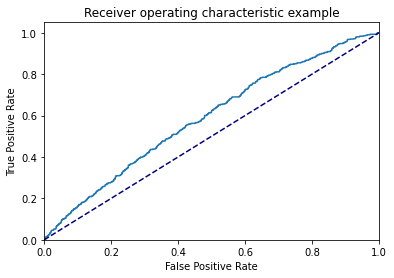

In [12]:
print(roc_auc_score(compare['actual'], compare['predict']))

fpr, tpr, thresholds = roc_curve(compare['actual'], compare['predict'])
display1 = RocCurveDisplay(fpr=fpr, tpr=tpr)
display1.plot()
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.show()

### GAM (with logit link function) to predict `is_fraud`

In [ ]:
# x_spline = X_train[['log_age', 'log_city_pop']]
# bs = BSplines(x_spline, df=[10, 10], degree=[3, 3])
# gam_bs = GLMGam.from_formula('is_fraud ~ dow', data=X_train, smoother=bs, link = LogitGam.link())
# res_bs = gam_bs.fit()
# print(res_bs.summary())

In [13]:
gam = LogisticGAM().fit(X2_train, y_train)
gam.summary()

/Users/rohan/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     33.1045
Link Function:                        LogitLink Log Likelihood:                                 -23569.407
Number of Samples:                      1500000 AIC:                                            47205.0229
                                                AICc:                                           47205.0245
                                                UBRE:                                               2.0315
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3188
Feature Function                  Lam

<ipython-input-13-d2cc9e67f30b>:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [14]:
predictions = gam.predict_proba(X2_test)
compare2 = pd.DataFrame({'actual': y_test['is_fraud'], 'predict' : predictions})
compare2.head()

,actual,predict
1500000,0,0.001449
1500001,0,0.002038
1500002,0,0.045798
1500003,0,0.070150
1500004,0,0.001381


0.8692402082644415


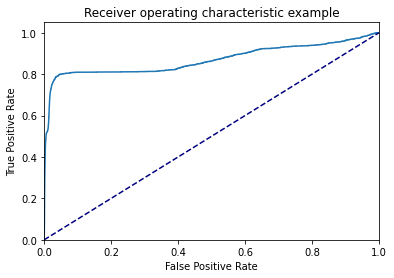

In [15]:
print(roc_auc_score(compare2['actual'], compare2['predict']))

fpr, tpr, thresholds = roc_curve(compare2['actual'], compare2['predict'])
display1 = RocCurveDisplay(fpr=fpr, tpr=tpr)
display1.plot()
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.show()

## Tree model to predict `is_fraud`

In [16]:
dtc = DecisionTreeClassifier(max_depth=8).fit(X3_train,y_train)
predictions = dtc.predict_proba(X3_test)
compare3 = pd.DataFrame({'actual': y_test['is_fraud'], 'predict' : predictions[:,1]})
compare3.head()

,actual,predict
1500000,0,0.001954
1500001,0,0.000012
1500002,0,0.010319
1500003,0,0.024165
1500004,0,0.000238


0.9682343578583132


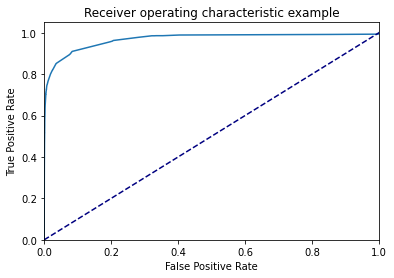

In [17]:
print(roc_auc_score(compare3['actual'], compare3['predict']))

fpr, tpr, thresholds = roc_curve(compare3['actual'], compare3['predict'])
display1 = RocCurveDisplay(fpr=fpr, tpr=tpr)
display1.plot()
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.show()